In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.collections import LineCollection

### Utility functions

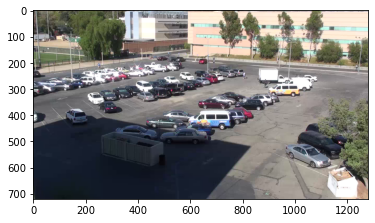

In [3]:
# load video into a generator of images
def v2i(filename, scale=1):
    cap = cv2.VideoCapture(filename)
    while(True):
        ret, frame = cap.read()
        if ret: 
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (frame.shape[1] // scale, frame.shape[0] // scale))
            yield frame
        else: break

# read video
path = 'videos/VIRAT_S_010111_08_000920_000954.mp4'
scale = 1
video = v2i(path, scale)
frame0 = next(video)
plt.imshow(frame0, cmap='gray')

In [3]:
# load the homographies
def load_homography(fname):
    """ Load a homography from a text file """
    return np.loadtxt(fname, delimiter=',')
    
path = 'homographies/VIRAT_0101_homography_img2world.txt'
H = load_homography(path)

print(H)

[[-2.9320106e-04  1.2073065e-03 -5.9184241e-01]
 [ 5.0597447e-04  9.6643864e-04 -8.0604973e-01]
 [ 7.7224635e-08 -4.5847150e-05  2.0273329e-03]]


### See what happens when we convert img --> world coords

Roughly estimated 3-by-3 homographies are included for convenience. 
Each homography H provides a mapping from image coordinate to scene-dependent world coordinate.

[xw,yw,zw]' = H*[xi,yi,1]'

xi: horizontal axis on image with left top corner as origin, increases right.
yi: vertical axis on image with left top corner as origin, increases downward.

xw/zw: world x coordinate
yw/zw: world y coordiante

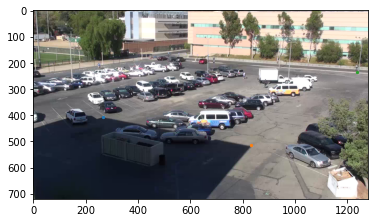

In [4]:
# pick some iamge coordinates
c1 = np.array([265, 405, 1])
c2 = np.array([830, 515, 1])
c3 = np.array([1237, 235, 1])

# plot on image
plt.figure()
plt.imshow(frame0)
plt.scatter(c1[0], c1[1], s=5)
plt.scatter(c2[0], c2[1], s=5)
plt.scatter(c3[0], c3[1], s=5)
plt.show()

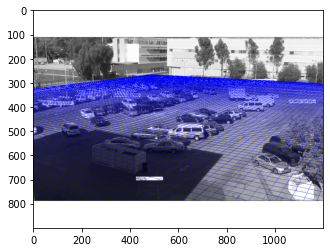

In [5]:
path = 'homographies/VIRAT_0101_homography_img2world.png'
img1 = cv2.imread(path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img1)

real world coord1 = [-0.18058156 -0.28055885 -0.0165203 ]
real world coord2 = [-0.21343644  0.11162498 -0.02151985]
real world coord2 = [-0.67081509  0.04695377 -0.00865122]
real world coord1 = [10.93088968 16.98267433  1.        ]
real world coord2 = [ 9.91811809 -5.18706983  1.        ]
real world coord3 = [77.53993735 -5.42741569  1.        ]


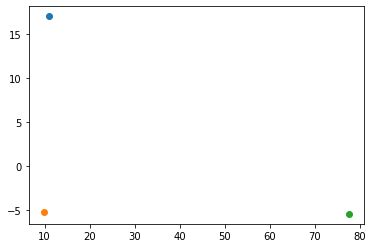

In [6]:
# get real world coordinates
r1 = H @ c1
r2 = H @ c2
r3 = H @ c3

print('real world coord1 = {}'.format(r1))
print('real world coord2 = {}'.format(r2))
print('real world coord2 = {}'.format(r3))
r1 = r1/r1[2]
r2 = r2/r2[2]
r3 = r3/r3[2]
print('real world coord1 = {}'.format(r1))
print('real world coord2 = {}'.format(r2))
print('real world coord3 = {}'.format(r3))

plt.figure()
#plt.gca().invert_yaxis()
plt.scatter(r1[0], r1[1])
plt.scatter(r2[0], r2[1])
plt.scatter(r3[0], r3[1])

This makes sense to me.
1. The orange dot should be approximately lined up with the green dot, and they should be "far" away from each other
2. The orange dot and blue dot should be slightly offset from each other and not as far away as the green dot
3. **We can definitely work with this by determining the width of a person based on the average height calculation, then use tht as our scale along the x-axis**

### Tool for later checking: verify that $H^{-1}$ gives ground plane

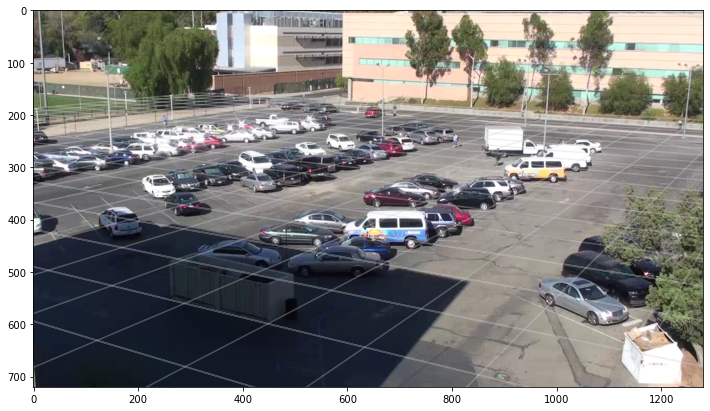

In [7]:
def plot_grid(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x, y), axis=2)
    segs2 = segs1.transpose(1, 0, 2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def world_to_image_plot(img, H, xrange, yrange, step=5, **kwargs):
    
    # get meshgrid
    height, width, channels = img.shape
    x = np.arange(xrange[0], xrange[1], step=step)
    y = np.arange(yrange[0], yrange[1], step=step)
    xx, yy = np.meshgrid(x, y)
    
    # deform points from world coords to image coords
    H_inv = np.linalg.inv(H)
    irange, jrange = yy.shape
    new_x = np.zeros(xx.shape)
    new_y = np.zeros(yy.shape)
    
    # find new coords
    for i in range(irange):
        for j in range(jrange):
            real_coord = [xx[i,j], yy[i,j], 1]
            img_coord = H_inv @ real_coord
            img_coord = img_coord / img_coord[2]
            new_x[i,j] = img_coord[0]
            new_y[i,j] = img_coord[1]
            
    # make indexable
    new_x = new_x.astype(int)
    new_y = new_y.astype(int)
    
    # plot
    fig, ax = plt.subplots(figsize=(12,12))
    #plot_grid(new_x, new_y, ax=ax, color="lightgrey", alpha=0.3)
    plot_grid(new_x, new_y, ax=ax, **kwargs)
    plt.imshow(img)
    
xrange = (-20, 100)
yrange = (-100, 100)
world_to_image_plot(frame0, H, xrange, yrange, color="lightgrey", alpha=0.3)
#world_to_image_plot(frame0, H, xrange, yrange, color="C0", alpha=0.3)

# Make GUI for point selections

In [41]:
# start position
x, y = -1, -1
points_list = []

def point_handler(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDBLCLK:
        # Drawing params (remember - in BGR)
        color = (0, 255, 0)  
        thickness = 1
        
        # add point to list and draw
        param[0].append((x,y))
        cv2.circle(img, (x,y), 2, (0, 0, 255), 2)      
        
        # standard drawing line btw points
        if len(param[0]) >= 2:
            p1 = param[0][-1]
            p2 = param[0][-2]
            cv2.line(img, p1, p2, color, thickness)
            
        # complete the square
        if len(param[0]) == 4:
            p1 = param[0][-1]
            p2 = param[0][0]
            cv2.line(img, p1, p2, color, thickness)

#img = np.zeros((512,512,3), np.uint8)
img = frame0.copy()
param = [points_list]
cv2.namedWindow('image')
cv2.setMouseCallback('image', point_handler, param)

while(1):
    cv2.imshow('image', img)
    key = cv2.waitKey(20)
    if key == 27:  #esc
        break
    elif key == 32:  # space
        print('{}, {}'.format(x, y))
cv2.destroyAllWindows()
print(points_list)

[(917, 380), (1067, 393), (963, 488), (779, 466)]


In [42]:
# compute the homography

# make destination points a square
# top left, top right, bottom right, bottom left
dst_pts = [(0, 0), (10, 0), (10, 10), (0, 10)]
src_pts = points_list

def reformat(points):
    return np.float32([[pt for pt in points]]).reshape(-1, 1, 2)

dst = reformat(dst_pts)
src = reformat(src_pts)

M, mask = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
print(M)

[[-2.45996644e-01 -3.94738802e-01  3.75579668e+02]
 [ 4.49506006e-02 -5.18660776e-01  1.55871394e+02]
 [-1.82622172e-04 -1.27436444e-02  1.00000000e+00]]


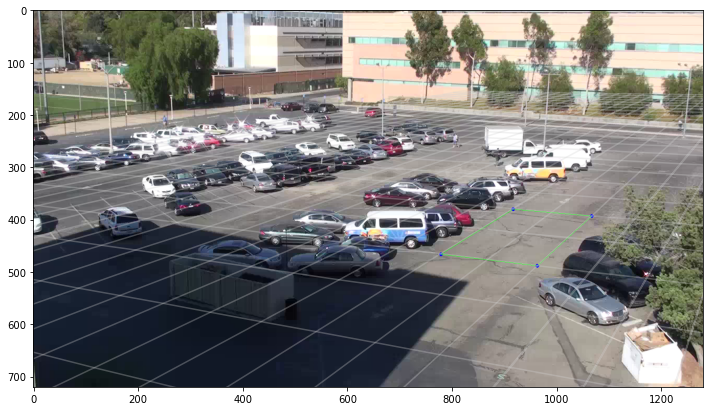

In [44]:
# see if homography is reasonably accurate
xrange = (-100, 100)
yrange = (-100, 50)
world_to_image_plot(img, M, xrange, yrange, color="lightgrey", alpha=0.3)


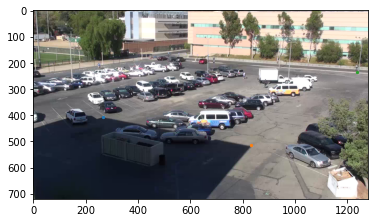

In [45]:
# pick some iamge coordinates
c1 = np.array([265, 405, 1])
c2 = np.array([830, 515, 1])
c3 = np.array([1237, 235, 1])

# plot on image
plt.figure()
plt.imshow(frame0)
plt.scatter(c1[0], c1[1], s=5)
plt.scatter(c2[0], c2[1], s=5)
plt.scatter(c3[0], c3[1], s=5)
plt.show()

real world coord1 = [150.52134214 -42.27431101  -4.20957086]
real world coord2 = [-31.88803014 -73.92990705  -5.71455327]
real world coord2 = [-21.4818      89.59000476  -2.22066006]
real world coord1 = [-35.75693275  10.0424277    1.        ]
real world coord2 = [ 5.580144   12.93712799  1.        ]
real world coord3 = [  9.67361028 -40.34386275   1.        ]


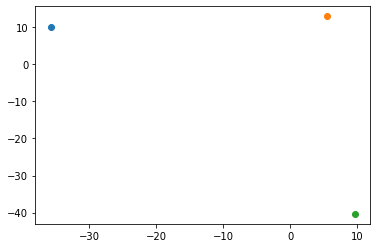

In [46]:
# get real world coordinates
r1 = M @ c1
r2 = M @ c2
r3 = M @ c3

print('real world coord1 = {}'.format(r1))
print('real world coord2 = {}'.format(r2))
print('real world coord2 = {}'.format(r3))
r1 = r1/r1[2]
r2 = r2/r2[2]
r3 = r3/r3[2]
print('real world coord1 = {}'.format(r1))
print('real world coord2 = {}'.format(r2))
print('real world coord3 = {}'.format(r3))

plt.figure()
#plt.gca().invert_yaxis()
plt.scatter(r1[0], r1[1])
plt.scatter(r2[0], r2[1])
plt.scatter(r3[0], r3[1])

### Upgrade GUI to allow for user to move points

In [12]:
# start position
x, y = -1, -1
points_list = []

def adjust_point(pt, point_list):
    """ 
    Expects pt = (x,y), point_list = [(x,y), (x,y)...]
    Modifies point_list in place
    """
    closest_dist = 100000000  # lol if you're working with an image this large
    tup = (0, 0)  # temp point
    tup_idx = 0   # temp index
    
    for idx, el in enumerate(point_list):
        x1, y1 = el
        x2, y2 = pt
        dist = np.sqrt( (x1-x2)**2 + (y1-y2)**2 )
        if dist < closest_dist:
            closest_dist = dist
            tup = (x2, y2)
            tup_idx = idx
            
    # modify list in place
    point_list[tup_idx] = tup

def point_handler(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDBLCLK:
        # if we don't have all of our points yet, add it to the list
        if len(param[0]) < 4:
            param[0].append((x,y))
            
        # if we already have all of our points, make sure to change closest
        else:
            adjust_point((x,y), param[0])


def draw_points(new_img, point_list):
    # Draw lines between points if possible
    line_color = (0, 255, 0)
    line_thickness = 1
    for i in range(len(point_list)):
        if i >= 1:
            p1 = point_list[i-1]
            p2 = point_list[i]
            new_img = cv2.line(new_img, p1, p2, line_color, line_thickness)
            
        # complete the square
        if i == 3:
            p1 = point_list[0]
            p2 = point_list[3]
            new_img = cv2.line(new_img, p1, p2, line_color, line_thickness)            
    
    # Draw each point
    point_color = (0, 0, 255)
    for pt in point_list:
        new_img = cv2.circle(new_img, pt, 2, point_color, 2)
         
    return new_img
        
img = frame0.copy()
param = [points_list]
cv2.namedWindow('image')
cv2.setMouseCallback('image', point_handler, param)

while(1):
    # Keep old image cached
    new_img = img.copy()
    
    # handle drawing
    new_img = draw_points(new_img, param[0])
    cv2.imshow('image', new_img)
    
    key = cv2.waitKey(20)
    if key == 27:  #esc - to get out of loop
        break
    elif key == 32:  # space - help with debugging
        #print('{}, {}'.format(x, y))
        print(len(param[0]))
        
cv2.destroyAllWindows()
print(points_list)

[(382, 388), (558, 333), (729, 354), (574, 423)]
